In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [30]:
cleansed=load_amihud_markets_price()

In [34]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [35]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [36]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


In [37]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,3)

In [38]:
factors=pd.DataFrame()
for s in ['Agriculturals',
         'Energies',
         'Equities',
         'Metals',
         'Fixed Income']:
    factors[s]=sector_portfolio_sorts[s]['2']-sector_portfolio_sorts[s]['0']


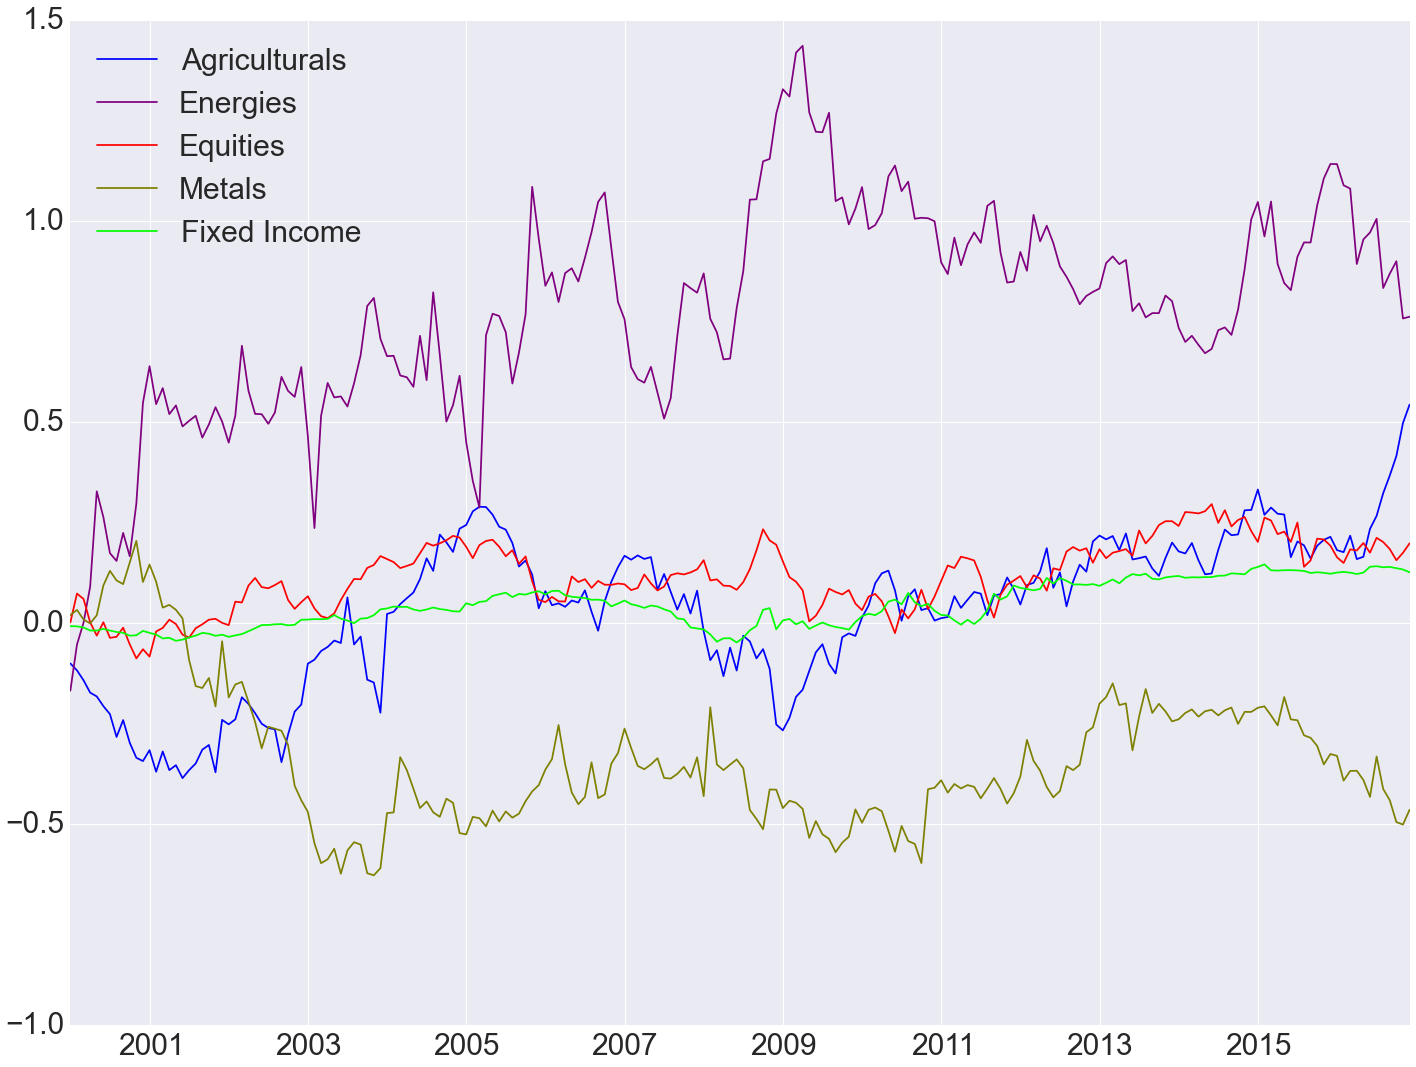

In [42]:
factors.cumsum().plot(colormap='brg')

In [43]:
final_res=pd.DataFrame()
alpha=[]
tstat=[]
for sec in factors.columns:
    ind=factors.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha.append(res.params.const)
    tstat.append(res.tvalues.const)
final_res['alpha1']=pd.Series(alpha)*100
final_res['tstat']=pd.Series(tstat)

KeyError: 'Agriculturals'

# FHT Annual portfolio sorts

In [11]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

tsmom_model.py:283: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:284: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:285: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:285: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [12]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,3)

In [13]:
factors_FHT=pd.DataFrame()
for s in ['Commodities', 'Equities', 'Fixed Income']:
    factors_FHT[s]=sector_portfolio_sorts[s]['2']-sector_portfolio_sorts[s]['0']


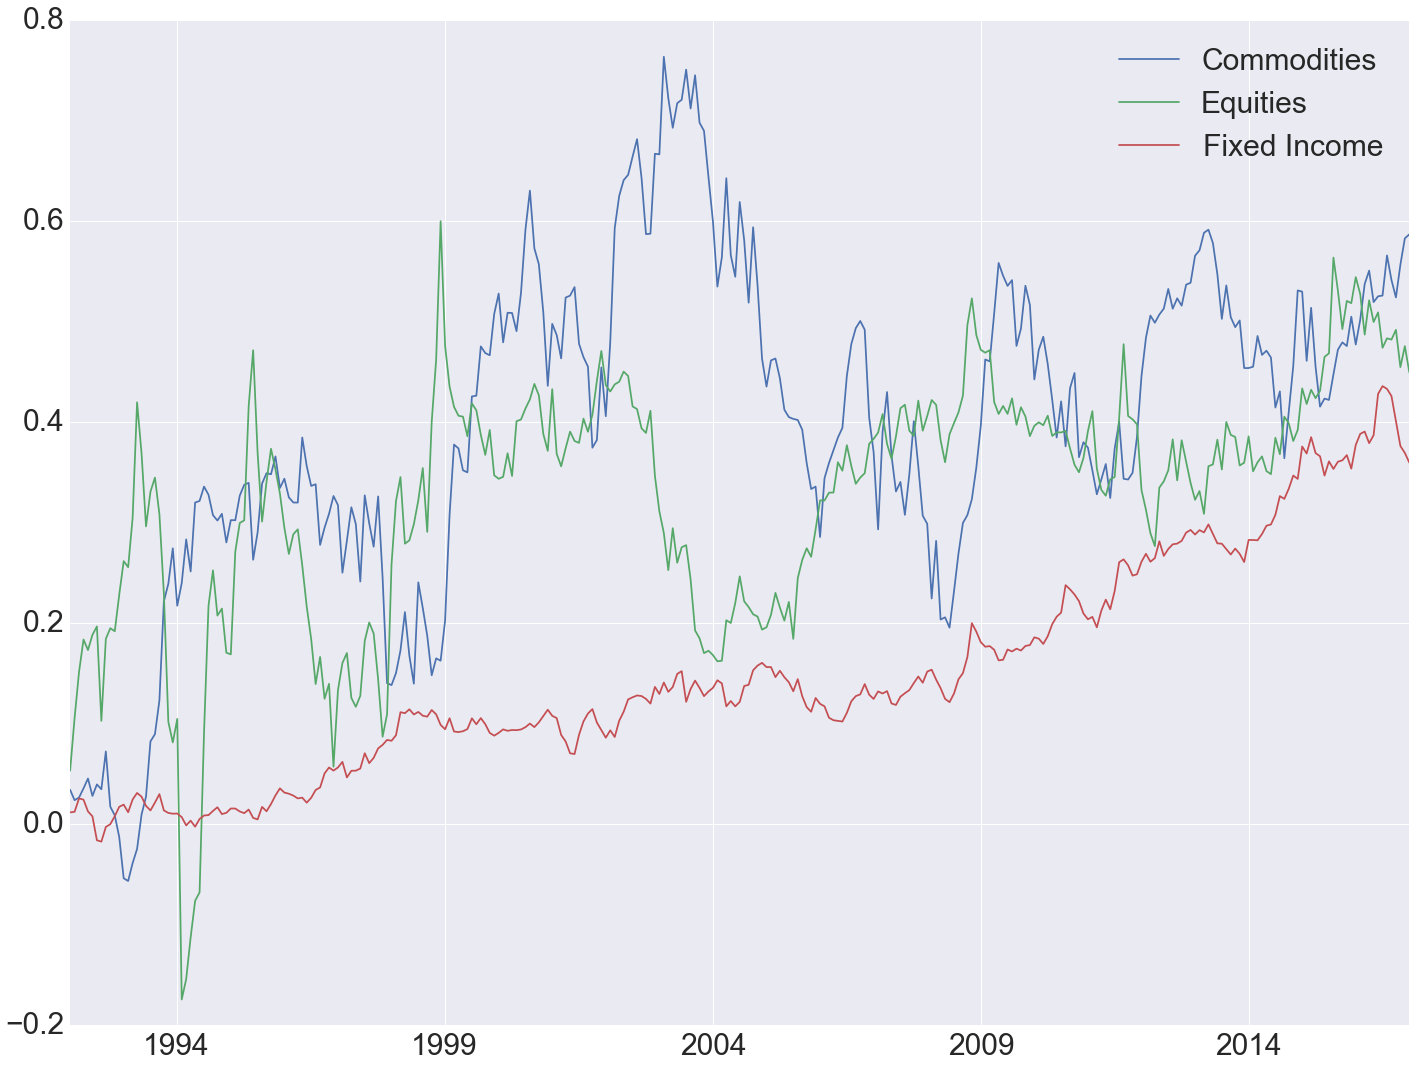

In [14]:
factors_FHT.cumsum().plot()

In [33]:
alpha=[]
tstat=[]
for sec in factors_FHT.columns:
    ind=factors_FHT.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_FHT[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha.append(res.params.const)
    tstat.append(res.tvalues.const)
final_res['alpha F-A']=pd.Series(alpha)*100
final_res['tstat2']=pd.Series(tstat)

# Monthly portoflio sorts

In [16]:
amihud_monthly = read_monthly(amihud=True)

In [17]:
factors_monthly=pd.DataFrame()
for s in ['Commodities', 'Equities', 'Fixed Income']:
    factors_monthly[s]=amihud_monthly[s]['2']-amihud_monthly[s]['0']


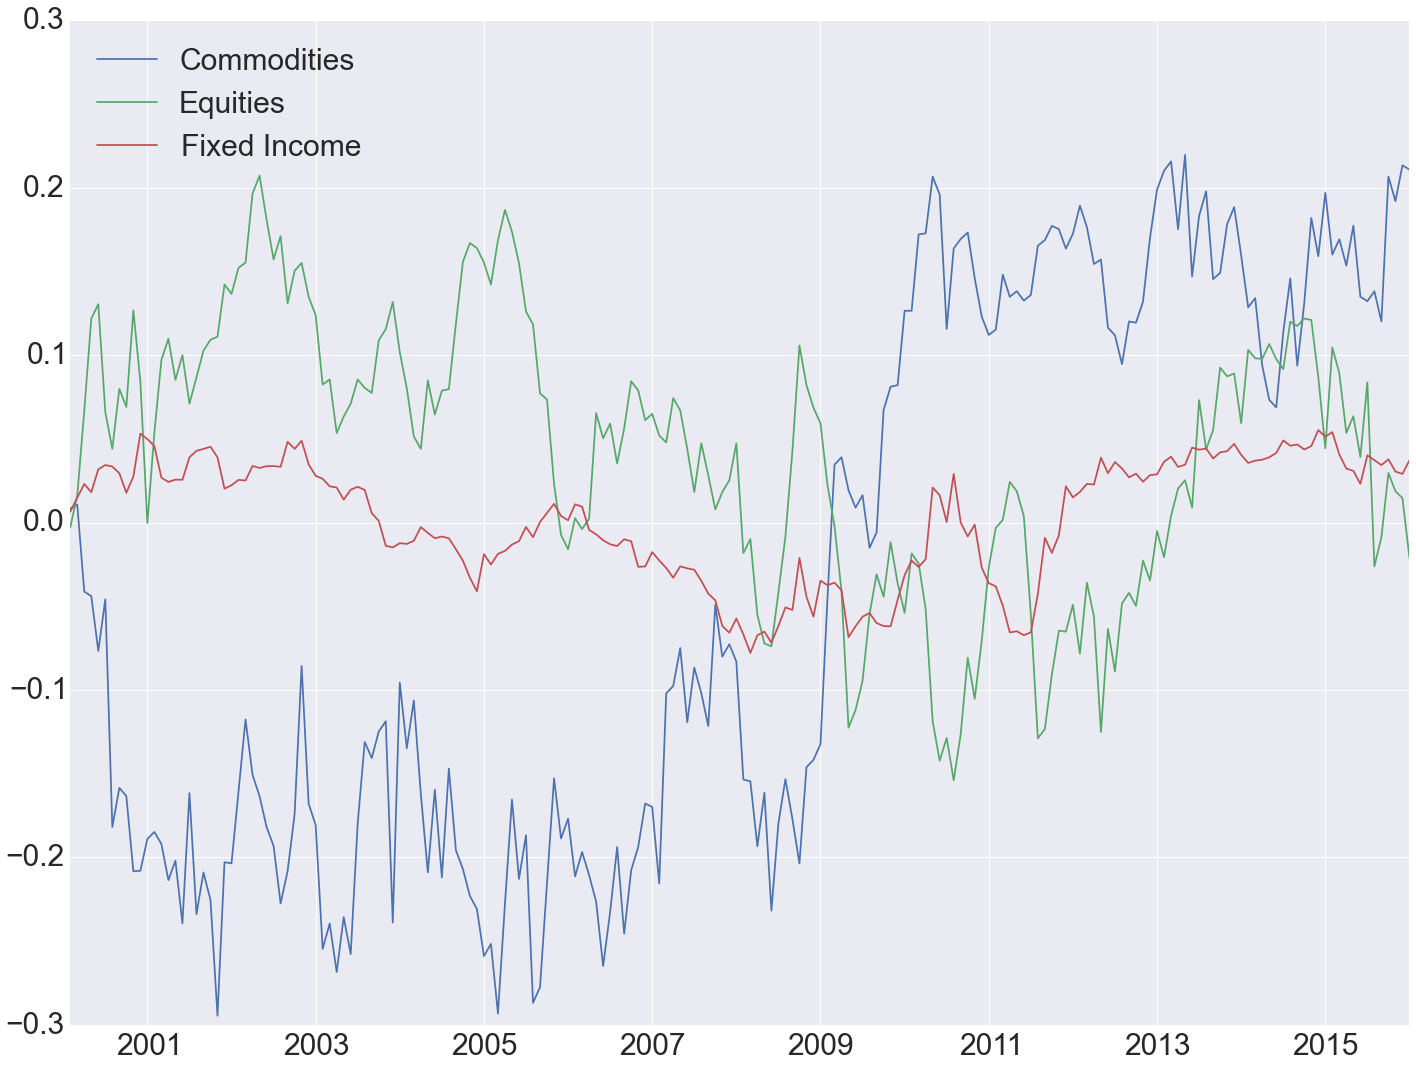

In [18]:
factors_monthly.cumsum().plot()

In [34]:
alpha=[]
tstat=[]
for sec in factors_monthly.columns:
    ind=factors_monthly.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_monthly[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha.append(res.params.const)
    tstat.append(res.tvalues.const)
final_res['alpha A-M']=pd.Series(alpha)*100
final_res['tstat3']=pd.Series(tstat)

# Monthly FHT

In [20]:
FHT_monthly = read_monthly(amihud=False)

In [21]:
factors_monthly_FHT=pd.DataFrame()
for s in ['Commodities', 'Equities', 'Fixed Income']:
    factors_monthly_FHT[s]=FHT_monthly[s]['2']-FHT_monthly[s]['0']


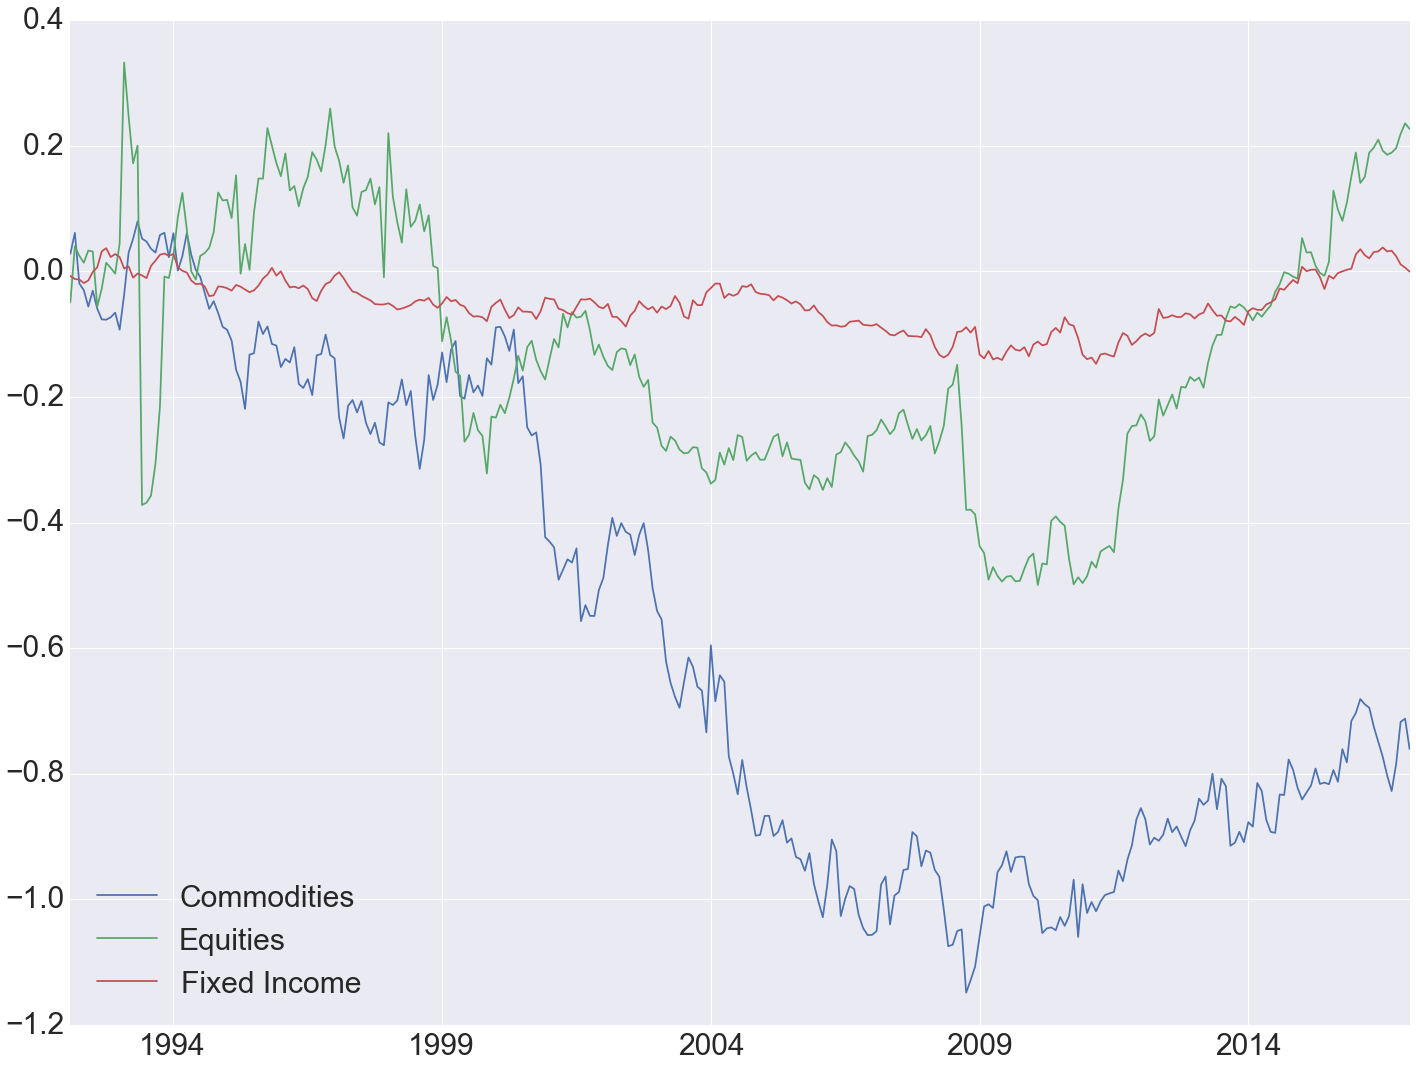

In [22]:
factors_monthly_FHT.cumsum().plot()

In [35]:
alpha=[]
tstat=[]
for sec in factors_monthly_FHT.columns:
    ind=factors_monthly_FHT.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_monthly_FHT[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha.append(res.params.const)
    tstat.append(res.tvalues.const)
final_res['alpha F-M']=pd.Series(alpha)*100
final_res['tstat4']=pd.Series(tstat)

In [38]:
df=final_res.set_index(factors.columns)

# Alpha values 

$$r_{liquidity,t} = \alpha + \beta_1 r_{AssetClass,t} + \beta_2 MOM_{AssetClass,t} +
\beta_3 VAL_{AssetClass,t} + \varepsilon_t $$

In [39]:
print(df.T.round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Commodities &  Equities &  Fixed Income \\
\midrule
alpha1    &         0.19 &      0.05 &          0.07 \\
tstat     &         0.78 &      0.25 &          0.91 \\
alpha F-A &         0.29 &      0.13 &          0.06 \\
tstat2    &         1.21 &      0.49 &          1.39 \\
alpha A-M &         0.20 &      0.03 &          0.04 \\
tstat3    &         0.82 &      0.14 &          0.57 \\
alpha F-M &        -0.26 &      0.07 &         -0.04 \\
tstat4    &        -1.23 &      0.24 &         -0.74 \\
\bottomrule
\end{tabular}

